In [1]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import animation
from matplotlib.animation import PillowWriter


In [2]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.output(x)


In [3]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # Hiperparámetros
        self.gamma = 0.99
        self.epsilon = 1.0  # Valor inicial de epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory = deque(maxlen=10000)
        
        # Redes neuronales
        self.policy_net = DQN(state_size, action_size)
        self.target_net = DQN(state_size, action_size)
        self.update_target_network()
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        with torch.no_grad():
            action_values = self.policy_net(state)
        return np.argmax(action_values.numpy())
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        
        states = torch.FloatTensor([m[0][0] for m in minibatch])
        actions = torch.LongTensor([m[1] for m in minibatch]).unsqueeze(1)
        rewards = torch.FloatTensor([m[2] for m in minibatch])
        next_states = torch.FloatTensor([m[3][0] for m in minibatch])
        dones = torch.FloatTensor([float(m[4]) for m in minibatch])
        
        # Obtener Q(s,a) de la red de políticas
        q_values = self.policy_net(states).gather(1, actions)
        
        # Obtener Q(s',a') de la red objetivo
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
        
        # Calcular el valor objetivo
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        target_q_values = target_q_values.unsqueeze(1)
        
        # Calcular la pérdida
        loss = self.criterion(q_values, target_q_values)
        
        # Optimizar la red
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Reducir epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [12]:
# Crear el ambiente sin renderizado por ahora
env = gym.make('CartPole-v1')  # Sin render_mode aquí
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

episodes = 1000  # Puedes ajustar el número de episodios
target_update = 10
scores = []

# Para almacenar las puntuaciones promedio
average_scores = []

# Intervalo para generar GIFs
gif_interval = 100  # Cada 100 episodios

for e in range(episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    terminated = False
    truncated = False
    while not (terminated or truncated):
        # Elegir acción
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay()
        if done:
            print(f"Episodio: {e+1}/{episodes}, Puntuación: {total_reward}, Epsilon: {agent.epsilon:.2}")
            break
    scores.append(total_reward)
    average_score = np.mean(scores[-100:])  # Promedio de los últimos 100 episodios
    average_scores.append(average_score)
    # Actualizar la red objetivo cada cierto número de episodios
    if e % target_update == 0:
        agent.update_target_network()
    # Generar GIF cada 'gif_interval' episodios
    if (e + 1) % gif_interval == 0:
        # Ejecutar un episodio de evaluación y capturar frames
        frames = []
        eval_env = gym.make('CartPole-v1', render_mode='rgb_array')
        state, _ = eval_env.reset()
        state = np.reshape(state, [1, state_size])
        terminated = False
        truncated = False
        while not (terminated or truncated):
            frame = eval_env.render()
            frames.append(frame)
            action = np.argmax(agent.policy_net(torch.FloatTensor(state)).detach().numpy())
            next_state, _, terminated, truncated, _ = eval_env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            state = next_state
        eval_env.close()
        # Crear y guardar el GIF
        fig = plt.figure()
        plt.axis('off')
        im = plt.imshow(frames[0], animated=True)

        def updatefig(i):
            im.set_array(frames[i])
            return [im]

        ani = animation.FuncAnimation(fig, updatefig, frames=range(len(frames)), interval=50, blit=True)
        gif_filename = f'cartpole_training_episode_{e+1}.gif'
        ani.save(gif_filename, writer='pillow')
        plt.close()
        print(f'GIF guardado como {gif_filename}')


Episodio: 1/1000, Puntuación: 22.0, Epsilon: 1.0
Episodio: 2/1000, Puntuación: 25.0, Epsilon: 1.0
Episodio: 3/1000, Puntuación: 34.0, Epsilon: 0.91
Episodio: 4/1000, Puntuación: 34.0, Epsilon: 0.77
Episodio: 5/1000, Puntuación: 19.0, Epsilon: 0.7
Episodio: 6/1000, Puntuación: 12.0, Epsilon: 0.66
Episodio: 7/1000, Puntuación: 26.0, Epsilon: 0.58
Episodio: 8/1000, Puntuación: 11.0, Epsilon: 0.55
Episodio: 9/1000, Puntuación: 12.0, Epsilon: 0.52
Episodio: 10/1000, Puntuación: 23.0, Epsilon: 0.46
Episodio: 11/1000, Puntuación: 11.0, Epsilon: 0.44
Episodio: 12/1000, Puntuación: 24.0, Epsilon: 0.39
Episodio: 13/1000, Puntuación: 11.0, Epsilon: 0.37
Episodio: 14/1000, Puntuación: 10.0, Epsilon: 0.35
Episodio: 15/1000, Puntuación: 9.0, Epsilon: 0.33
Episodio: 16/1000, Puntuación: 24.0, Epsilon: 0.29
Episodio: 17/1000, Puntuación: 10.0, Epsilon: 0.28
Episodio: 18/1000, Puntuación: 14.0, Epsilon: 0.26
Episodio: 19/1000, Puntuación: 12.0, Epsilon: 0.25
Episodio: 20/1000, Puntuación: 10.0, Epsilon

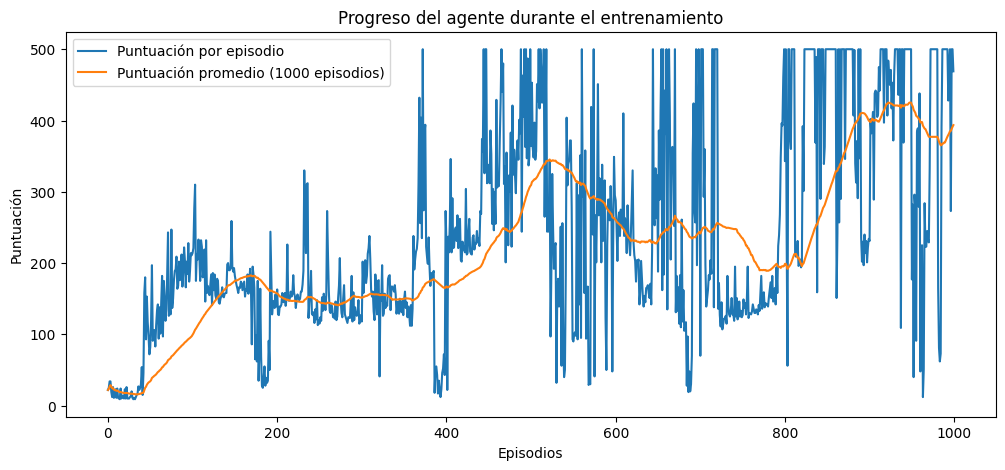

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(scores, label='Puntuación por episodio')
plt.plot(average_scores, label='Puntuación promedio (1000 episodios)')
plt.xlabel('Episodios')
plt.ylabel('Puntuación')
plt.title('Progreso del agente durante el entrenamiento')
plt.legend()
plt.show()


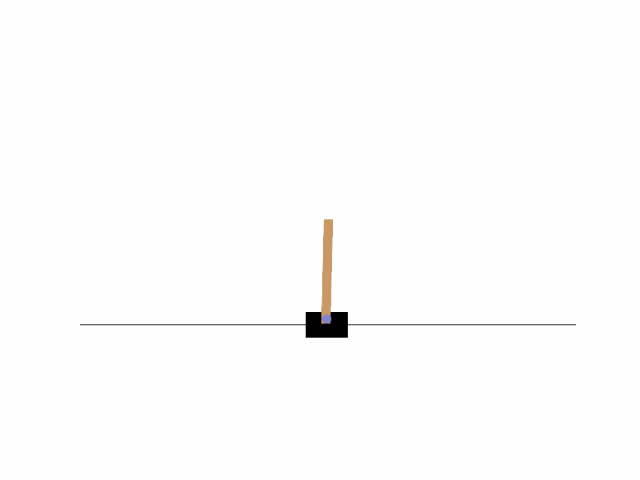

In [14]:
from IPython.display import Image

# Mostrar el GIF del episodio 100
Image(open('cartpole_training_episode_1000.gif','rb').read())


In [7]:
# Evaluación final
eval_env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = eval_env.reset()
state = np.reshape(state, [1, state_size])
terminated = False
truncated = False
frames = []
total_reward = 0

while not (terminated or truncated):
    frame = eval_env.render()
    frames.append(frame)
    action = np.argmax(agent.policy_net(torch.FloatTensor(state)).detach().numpy())
    next_state, reward, terminated, truncated, _ = eval_env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    total_reward += reward

eval_env.close()
print(f'Puntuación total en la evaluación final: {total_reward}')

# Crear y guardar el GIF de la evaluación final
fig = plt.figure()
plt.axis('off')
im = plt.imshow(frames[0], animated=True)

def updatefig(i):
    im.set_array(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, updatefig, frames=range(len(frames)), interval=50, blit=True)
ani.save('cartpole_evaluation_final.gif', writer='pillow')
plt.close()
print('GIF de la evaluación final guardado como cartpole_evaluation_final.gif')


Puntuación total en la evaluación final: 220.0
GIF de la evaluación final guardado como cartpole_evaluation_final.gif
